# CONEXIÓN a API DE BLUESKY

In [39]:
import requests

url = "https://bsky.social/xrpc/app.bsky.feed.getAuthorFeed"

url_se = "https://bsky.social/xrpc/com.atproto.server.createSession"
payload = {
  "identifier": "grupo18.bsky.social",
  "password":'Grupo18*BS'
}
response_tk = requests.post(url_se, json=payload)
response_tk.raise_for_status()
token = response_tk.json()["accessJwt"]  # Token de acceso


## Búsqueda de actores por palabras clave

In [41]:
import requests
import pandas as pd

# URL del endpoint de búsqueda de actores
url = "https://bsky.social/xrpc/app.bsky.actor.searchActors"

# Parámetros de búsqueda
params = {
    "term": "bloomberg",  # Término de búsqueda
    "limit": 10  # Número de resultados a mostrar
}

# Headers con el token de autenticación
headers = {
    "Authorization": f"Bearer {token}"
}

# Realizar la petición
response = requests.get(url, headers=headers, params=params)
response.raise_for_status()

# Procesar la respuesta
search_data = response.json()
actors = []

for actor in search_data['actors']:
    actor_data = {
        'did': actor['did'],
        'handle': actor['handle'],
        'display_name': actor.get('displayName', ''),
        'description': actor.get('description', ''),
        'followers_count': actor.get('followersCount', 0),
        'follows_count': actor.get('followsCount', 0),
        'posts_count': actor.get('postsCount', 0)
    }
    actors.append(actor_data)

# Crear y mostrar el DataFrame
df_actors = pd.DataFrame(actors)
print("\nResultados de búsqueda de actores:")
display(df_actors)


Resultados de búsqueda de actores:


,did,handle,display_name,description,followers_count,follows_count,posts_count
0,did:plc:uewxgchsjy4kmtu7dcxa77us,bloomberg.com,Bloomberg News,The first word in business news. \nNewsletters...,0,0,0
1,did:plc:djdxfzbvmvjmjlj3qu32uy2i,daveweigel.bsky.social,Dave Weigel,National politics reporter at semafor.com. Alu...,0,0,0
2,did:plc:2mkgbhbhqvappkkorf2bzyrp,jasonschreier.bsky.social,Jason Schreier,Reporter at Bloomberg | co-host of Triple Clic...,0,0,0
3,did:plc:mwwn3r5llzsfassowreprqus,amandamull.bsky.social,Amanda Mull,Senior reporter and Buying Power columnist at ...,0,0,0
4,did:plc:eeitvtxcbjt3vmljqfmwzahz,jasonleopold.bsky.social,Jason Leopold,"Investigative Reporter, Bloomberg News. ""FOIA ...",0,0,0
5,did:plc:p2gx4zjzdv3t55mll7iiuov3,davey.bsky.social,Davey Alba,"Bloomberg tech reporter / Google, Big Tech, mi...",0,0,0
6,did:plc:6edxc56gc2sntq6ht6epjug4,steventdennis.bsky.social,Steven T. Dennis,I cover the U.S. Senate for Bloomberg News. Yo...,0,0,0
7,did:plc:q5wqr7zofdqyqwoki4cby36x,conorsen.bsky.social,Conor Sen,"Bloomberg Opinion columnist, Buc-ee’s fan\n\n📍...",0,0,0
8,did:plc:ui32plrlzbu7h2xhbqngeu7s,heidireports.bsky.social,Heidi Przybyla 🎤✍️,"Award-winning print, digital and TV investigat...",0,0,0
9,did:plc:pnx2fjuannbdpy3337ggthpp,peark.es,George Pearkes,No longer Bluesky’s only resident finance bro ...,0,0,0


In [42]:
# Colocamos el actor que preferimos de la lista de actores  
params = {
  "actor": "bloomberg.com",
  "limit": 25
}

url = "https://bsky.social/xrpc/app.bsky.feed.getAuthorFeed"

headers = {
  "Authorization": f"Bearer {token}"
}

response = requests.get(url, headers=headers, params=params)
response.raise_for_status()

## Transformar las salida de la API en un Panda

In [43]:
import pandas as pd
from datetime import datetime

# Crear DataFrame con los resultados
feed_data = response.json()
posts = []

for post in feed_data['feed']:
    post_data = {
        'uri': post['post']['uri'],
        'text': post['post']['record'].get('text', ''),
        'created_at': datetime.fromisoformat(post['post']['record']['createdAt'].replace('Z', '+00:00')),
        'likes': post['post']['likeCount'],
        'reposts': post['post']['repostCount'],
        'replies': post['post']['replyCount']
    }
    posts.append(post_data)

df = pd.DataFrame(posts)
print("\nFeed de unusualwhales.bsky.social:")
display(df)


Feed de unusualwhales.bsky.social:


,uri,text,created_at,likes,reposts,replies
0,at://did:plc:uewxgchsjy4kmtu7dcxa77us/app.bsky...,President Donald Trump will consider a proposa...,2025-04-01 22:21:45.528000+00:00,31,12,10
1,at://did:plc:uewxgchsjy4kmtu7dcxa77us/app.bsky...,Trump’s reciprocal tariffs have sparked fears ...,2025-04-01 22:20:39.708000+00:00,52,13,8
2,at://did:plc:uewxgchsjy4kmtu7dcxa77us/app.bsky...,Trump's oil policies have Wall Street rethinki...,2025-04-01 21:19:18.329000+00:00,32,8,11
3,at://did:plc:b6nazhaza26jp3eog5ue4ipt/app.bsky...,The National Weather Service will stop issuing...,2025-04-01 20:52:28.559000+00:00,642,384,42
4,at://did:plc:eeitvtxcbjt3vmljqfmwzahz/app.bsky...,"NEW: CDC FOIA page are being dismantled, inclu...",2025-04-01 19:52:02.161000+00:00,571,353,27
5,at://did:plc:q7iggtywwxvr7hr7axinzt6q/app.bsky...,Is this really the end of American exceptional...,2025-04-01 17:30:16.213000+00:00,32,10,14
6,at://did:plc:uewxgchsjy4kmtu7dcxa77us/app.bsky...,Conservative media outlet Newsmax is having a ...,2025-04-01 18:21:15.010000+00:00,28,10,6
7,at://did:plc:uewxgchsjy4kmtu7dcxa77us/app.bsky...,President Donald Trump’s sweeping tariffs will...,2025-04-01 18:12:00.400000+00:00,51,22,31
8,at://did:plc:uewxgchsjy4kmtu7dcxa77us/app.bsky...,Analysts at Bloomberg Intelligence have sifted...,2025-04-01 17:57:31.978000+00:00,9,3,4
9,at://did:plc:uewxgchsjy4kmtu7dcxa77us/app.bsky...,"Once considered obscure or opportunistic, inva...",2025-04-01 17:25:31.575000+00:00,87,35,9


## Análisis preliminar aplicando minería de texto básica sobre el panda de posts obtenidos de BLUESKY

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\FSONZOGNI\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\FSONZOGNI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\FSONZOGNI\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


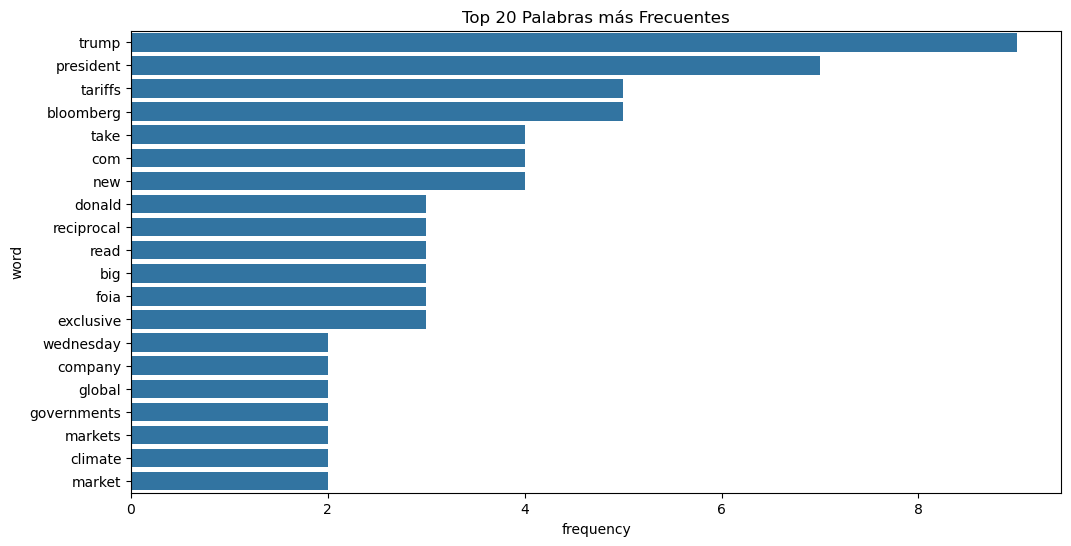


Frecuencia de palabras:


,word,frequency
0,trump,9
1,president,7
2,tariffs,5
3,bloomberg,5
4,take,4
5,com,4
6,new,4
7,donald,3
8,reciprocal,3
9,read,3


In [45]:
# Nueva celda para análisis de texto
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Descargar todos los recursos necesarios de NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

def analyze_text(text_series):
    # Convertir a minúsculas y unir todos los textos
    all_text = ' '.join(text_series.str.lower())
    
    # Limpiar el texto de caracteres especiales y números
    all_text = re.sub(r'[^\w\s]', ' ', all_text)
    
    # Tokenizar el texto (usando un método más simple)
    tokens = all_text.split()
    
    # Eliminar stopwords y palabras cortas
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    
    # Contar frecuencia de palabras
    word_freq = Counter(filtered_tokens)
    
    # Crear DataFrame con las palabras más frecuentes
    df_word_freq = pd.DataFrame(word_freq.most_common(20), columns=['word', 'frequency'])
    
    # Visualizar las palabras más frecuentes
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_word_freq, x='frequency', y='word')
    plt.title('Top 20 Palabras más Frecuentes')
    plt.show()
    
    return df_word_freq

# Aplicar análisis al texto de los posts
word_frequency_df = analyze_text(df['text'])
print("\nFrecuencia de palabras:")
display(word_frequency_df)

## Análisis recomendado por el LLM de Cursos, a modo complementario al anterior

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\FSONZOGNI\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\FSONZOGNI\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\FSONZOGNI\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!



Estadísticas de Longitud de Posts:
       text_length  word_count
count    25.000000   25.000000
mean    171.080000   26.800000
std      45.928314    6.689544
min      91.000000   16.000000
25%     133.000000   22.000000
50%     174.000000   26.000000
75%     203.000000   33.000000
max     275.000000   38.000000


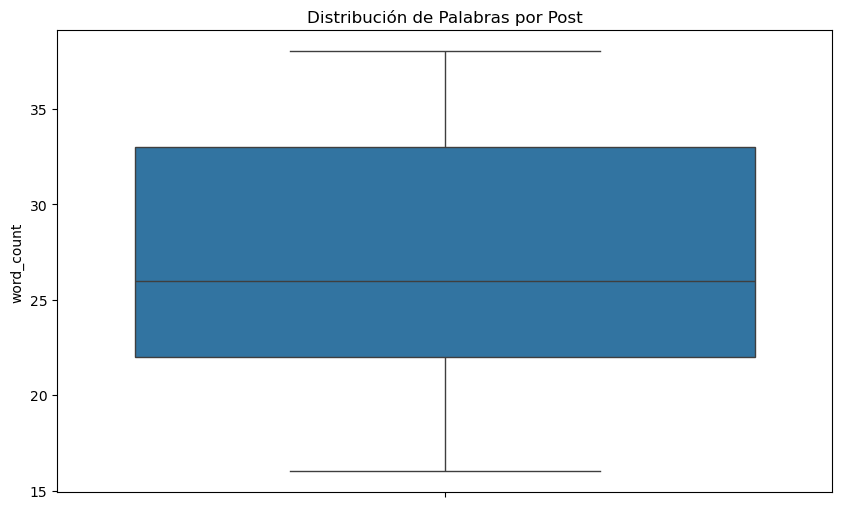

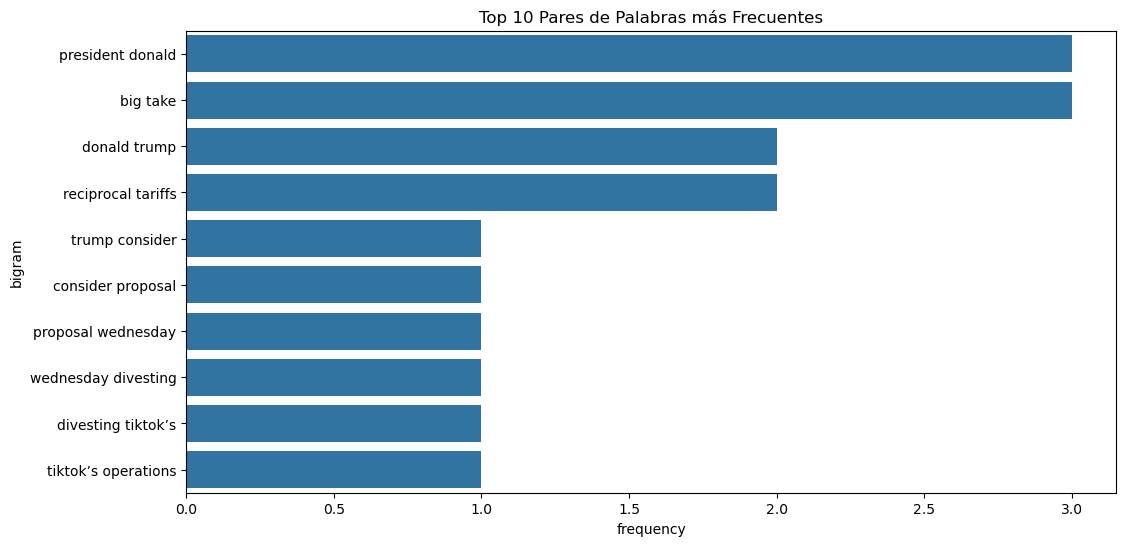

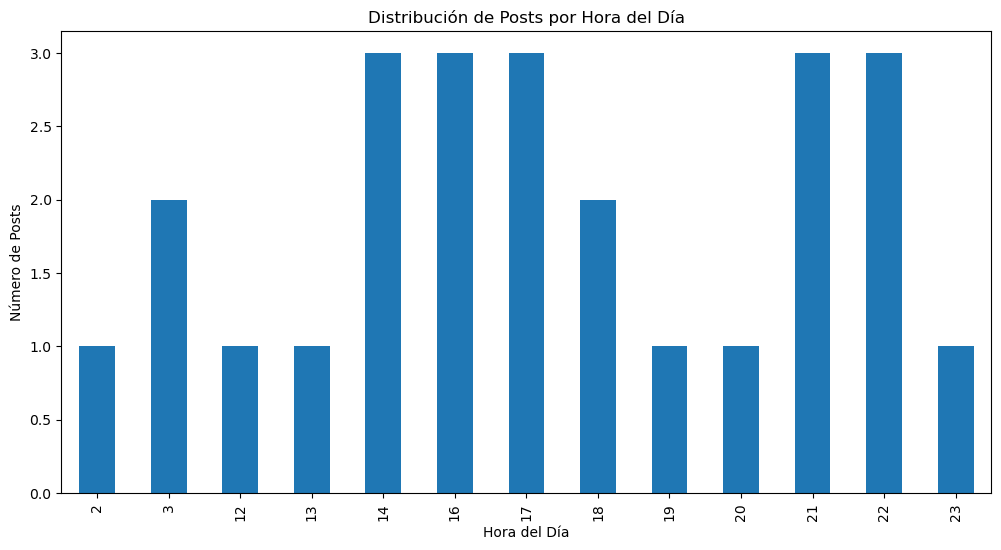


Hashtags más frecuentes:
[]

Menciones más frecuentes:
[('@bloomberg', 2), ('@weathersullivan', 1)]


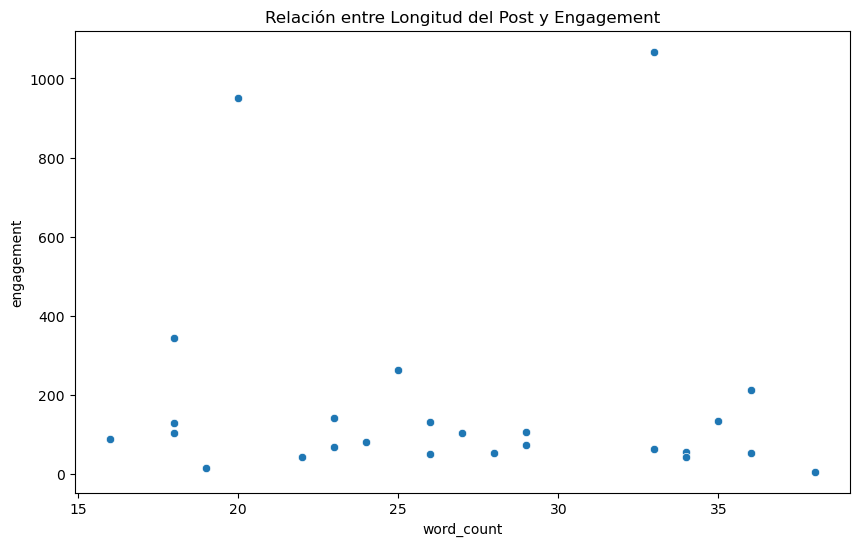


Palabras más frecuentes en posts de alto engagement:
[('president', 4), ('foia', 3), ('tariffs', 3), ('service', 2), ('donald', 2), ('trump’s', 2), ('take', 2), ('expensive', 2), ('would', 2), ('make', 2)]

Palabras más frecuentes en posts de bajo engagement:
[('new', 3), ('president', 2), ('company', 2), ('tariffs', 2), ('markets', 2), ("trump's", 2), ('climate', 2), ('read', 2), ('big', 2), ('take', 2)]


In [46]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime
import numpy as np

# Descargar recursos adicionales
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

def analyze_text_patterns(text_series):
    # 1. Análisis de Longitud de Posts
    df['text_length'] = df['text'].str.len()
    df['word_count'] = df['text'].str.split().str.len()
    
    print("\nEstadísticas de Longitud de Posts:")
    print(df[['text_length', 'word_count']].describe())
    
    # Visualización de longitud de posts
    plt.figure(figsize=(10, 6))
    sns.boxplot(y=df['word_count'])
    plt.title('Distribución de Palabras por Post')
    plt.show()
    
    # 2. Análisis de Bigramas (pares de palabras frecuentes)
    all_text = ' '.join(text_series.str.lower())
    words = all_text.split()
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words and len(word) > 2]
    bigrams = list(ngrams(words, 2))
    bigram_freq = Counter(bigrams)
    
    # Visualizar bigramas más frecuentes
    plt.figure(figsize=(12, 6))
    bigram_df = pd.DataFrame(bigram_freq.most_common(10), columns=['bigram', 'frequency'])
    bigram_df['bigram'] = bigram_df['bigram'].apply(lambda x: ' '.join(x))
    sns.barplot(data=bigram_df, x='frequency', y='bigram')
    plt.title('Top 10 Pares de Palabras más Frecuentes')
    plt.show()
    
    # 3. Análisis Temporal
    df['hour'] = df['created_at'].dt.hour
    hourly_posts = df.groupby('hour').size()
    
    plt.figure(figsize=(12, 6))
    hourly_posts.plot(kind='bar')
    plt.title('Distribución de Posts por Hora del Día')
    plt.xlabel('Hora del Día')
    plt.ylabel('Número de Posts')
    plt.show()
    
    # 4. Análisis de Hashtags y Menciones
    hashtags = re.findall(r'#\w+', all_text)
    mentions = re.findall(r'@\w+', all_text)
    
    print("\nHashtags más frecuentes:")
    print(Counter(hashtags).most_common(5))
    print("\nMenciones más frecuentes:")
    print(Counter(mentions).most_common(5))
    
    # 5. Análisis de Engagement
    df['engagement'] = df['likes'] + df['reposts'] + df['replies']
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='word_count', y='engagement')
    plt.title('Relación entre Longitud del Post y Engagement')
    plt.show()
    
    # 6. Análisis de Palabras Clave por Engagement
    high_engagement_posts = df[df['engagement'] > df['engagement'].median()]
    low_engagement_posts = df[df['engagement'] <= df['engagement'].median()]
    
    def get_top_words(posts, n=10):
        words = ' '.join(posts['text'].str.lower()).split()
        words = [word for word in words if word not in stop_words and len(word) > 2]
        return Counter(words).most_common(n)
    
    print("\nPalabras más frecuentes en posts de alto engagement:")
    print(get_top_words(high_engagement_posts))
    print("\nPalabras más frecuentes en posts de bajo engagement:")
    print(get_top_words(low_engagement_posts))
    
    return df

# Aplicar análisis
df = analyze_text_patterns(df['text'])

## Análisis de sentimiento

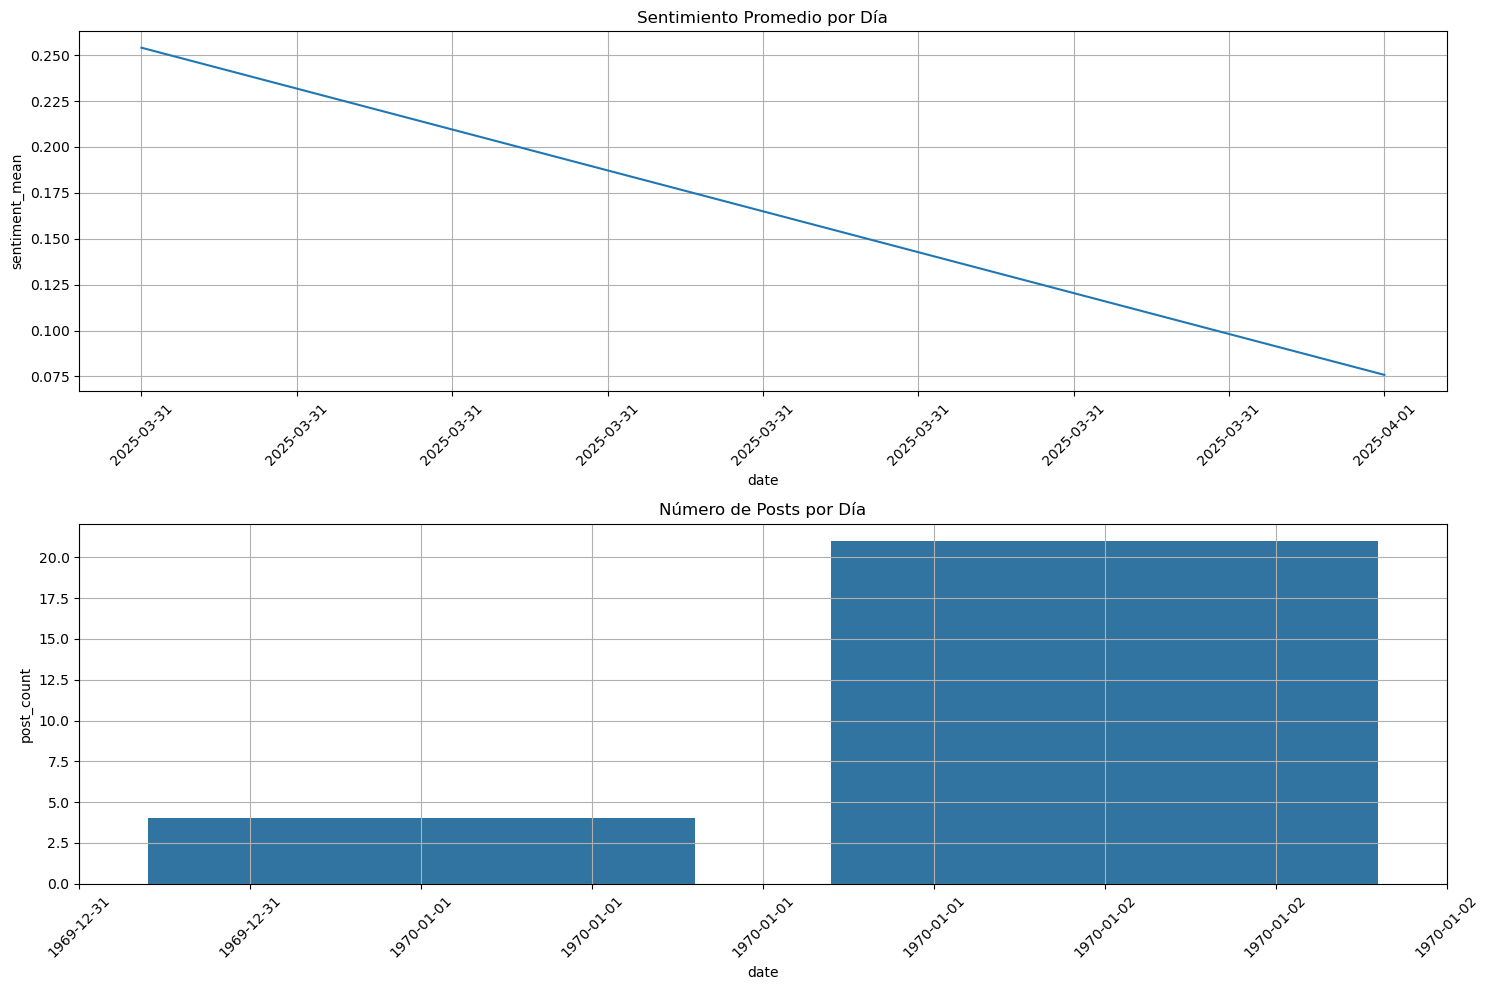


Estadísticas de Sentimiento por Día:
      date  sentiment_mean  post_count
2025-03-31        0.254103           4
2025-04-01        0.075830          21


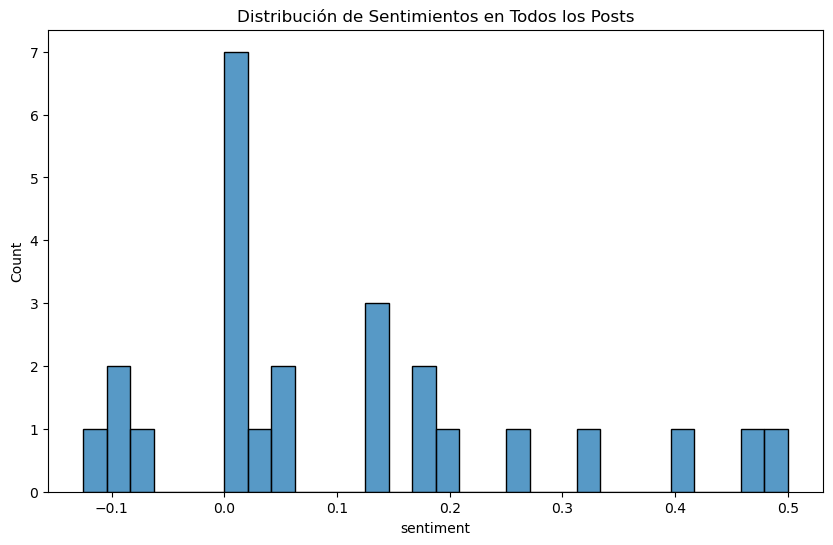


Estadísticas Generales de Sentimiento:
Sentimiento promedio general: 0.104
Posts positivos (>0.1): 11
Posts negativos (<-0.1): 1
Posts neutrales (-0.1 a 0.1): 13


In [48]:
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import matplotlib.dates as mdates

def analyze_sentiment_by_day(df):
    # Convertir created_at a fecha (sin hora)
    df['date'] = df['created_at'].dt.date
    
    # Función para calcular el sentimiento
    def get_sentiment(text):
        try:
            return TextBlob(str(text)).sentiment.polarity
        except:
            return 0
    
    # Calcular sentimiento para cada post
    df['sentiment'] = df['text'].apply(get_sentiment)
    
    # Agrupar por fecha y calcular estadísticas
    daily_sentiment = df.groupby('date').agg({
        'sentiment': ['mean', 'count'],
        'text': lambda x: ' '.join(x)  # Unir todos los textos del día
    }).reset_index()
    
    # Renombrar columnas
    daily_sentiment.columns = ['date', 'sentiment_mean', 'post_count', 'daily_text']
    
    # Calcular sentimiento promedio del día
    daily_sentiment['daily_sentiment'] = daily_sentiment['daily_text'].apply(get_sentiment)
    
    # Crear visualizaciones
    plt.figure(figsize=(15, 10))
    
    # Gráfico 1: Sentimiento promedio por día
    plt.subplot(2, 1, 1)
    ax1 = plt.gca()
    sns.lineplot(data=daily_sentiment, x='date', y='sentiment_mean')
    plt.title('Sentimiento Promedio por Día')
    
    # Formatear el eje X para mostrar fechas correctamente
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.xticks(rotation=45)
    plt.grid(True)
    
    # Gráfico 2: Número de posts por día
    plt.subplot(2, 1, 2)
    ax2 = plt.gca()
    sns.barplot(data=daily_sentiment, x='date', y='post_count')
    plt.title('Número de Posts por Día')
    
    # Formatear el eje X para mostrar fechas correctamente
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax2.xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.xticks(rotation=45)
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Mostrar estadísticas
    print("\nEstadísticas de Sentimiento por Día:")
    print(daily_sentiment[['date', 'sentiment_mean', 'post_count']].to_string(index=False))
    
    # Análisis adicional: Distribución de sentimientos
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='sentiment', bins=30)
    plt.title('Distribución de Sentimientos en Todos los Posts')
    plt.show()
    
    # Calcular estadísticas generales
    print("\nEstadísticas Generales de Sentimiento:")
    print(f"Sentimiento promedio general: {df['sentiment'].mean():.3f}")
    print(f"Posts positivos (>0.1): {len(df[df['sentiment'] > 0.1])}")
    print(f"Posts negativos (<-0.1): {len(df[df['sentiment'] < -0.1])}")
    print(f"Posts neutrales (-0.1 a 0.1): {len(df[(df['sentiment'] >= -0.1) & (df['sentiment'] <= 0.1)])}")
    
    return daily_sentiment

# Aplicar el análisis
daily_sentiment_df = analyze_sentiment_by_day(df)